<a href="https://colab.research.google.com/github/Sebas-Atehortua/Integracion-de-Datos-y-Prospectiva/blob/main/Modelo_Riesgo_FINTECH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Caracterización del Riesgo Operacional - Caso FINTECH**

El presente modelo tiene como objetivo estimar las pérdidas financieras de una FINTECH derivadas de fallos tecnológicos en sus canales electrónicos. Se busca caracterizar la Distribución Agregada de Pérdidas (LDA) para determinar el capital necesario para cubrir eventos de riesgo con un nivel de confianza del 99.9%.

Para ello, se describen las siguientes variables aleatorias para explicar este riesgo:

* **Frecuencia**: Como el número de transacciones que fallan al día. Se modela estadísticamente para entender cuántas veces ocurre el riesgo en un periodo determinado.
* **Severidad**: Define el impacto económico promedio (costo tecnológico) por cada evento de fallo. Este parámetro permite medir la magnitud individual de las pérdidas.
* **Distribución Agregada de Pérdidas (LDA)**: Que resulta de multiplicar ambas variables anteriores.

Dado que la pérdida agregada no es una simple multiplicación de promedios, utilizaremos el Método de Montecarlo para realizar la convolución de las distribuciones de frecuencia y severidad.

1. *Pérdidas Esperadas (EL)*: El promedio de la distribución resultante.
2. *Pérdidas No Esperadas (UL)*: El capital en riesgo calculado como la diferencia entre el escenario de estrés y la media ($UL = SL - EL$).
3. *Stress Losses (SL)*: El percentil 99.9% que representa las pérdidas catastróficas







0. Se cargan librerías de trabajo

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns # En esta librería se hará el trabajo estadístico
import matplotlib.pyplot as plt
import scipy.stats as stats

# Configuración de estilo
sns.set_theme(style="whitegrid")

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Se cargan los archivos de trabajo

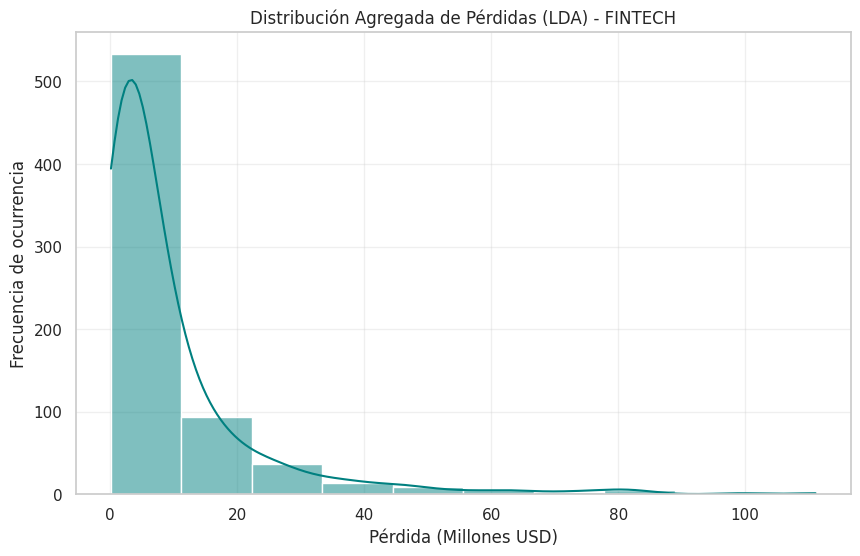

In [3]:
nxl='/content/drive/MyDrive/Proyecto FINTECH/1. FallasTecnológicas.xlsx'
XDB=pd.read_excel(nxl, sheet_name=0)
XDB.head(10)

# Procedemos con la construcción de la distribución agregada de las pérdidas
Freq=XDB.iloc[:,3]
Sev=XDB.iloc[:,4]
LDA=Freq*Sev

# Se procede con la construcción de la distribución agregada de las pérdidas

# Visualización inicial mediante la librería Seaborn

plt.figure(figsize=(10, 6))
sns.histplot(LDA, bins=10, kde=True, color='teal')
plt.title("Distribución Agregada de Pérdidas (LDA) - FINTECH")
plt.xlabel("Pérdida (Millones USD)")
plt.ylabel("Frecuencia de ocurrencia")
plt.grid(True, alpha=0.3)
plt.show()

2. Se procede con la clusterización estadística, la cual está definida mediante el Histograma de Frecuencias.

In [7]:
np.set_printoptions(precision=2, suppress=True)

NI = 10 # Número de intervalos/clústers
counts, bin_edges = np.histogram(LDA, bins=NI)

print("El número de datos por intervalo es:")
print(counts)
print("Los intervalos inferiores:")
print(bin_edges[:-1])
print("Los intervalos superiores:")
print(bin_edges[1:])
XC=(bin_edges[:-1]+bin_edges[1:])/2
print("Los intervalos centrales son:")
print(XC)

# Configuración de la tabla de clústers
XC = (bin_edges[:-1] + bin_edges[1:]) / 2 # Marcas de clase
Tabla = np.column_stack((bin_edges[:-1], bin_edges[1:], XC, counts))
df_clusters = pd.DataFrame(Tabla, columns=['Límite Inf', 'Límite Sup', 'Marca Clase', 'Frec. Absoluta'])


print("Tabla de Distribución de Frecuencias (LDA):")
display(df_clusters.head(NI))

El número de datos por intervalo es:
[533  93  37  14   9   5   3   5   1   1]
Los intervalos inferiores:
[ 0.14 11.24 22.33 33.42 44.52 55.61 66.71 77.8  88.89 99.99]
Los intervalos superiores:
[ 11.24  22.33  33.42  44.52  55.61  66.71  77.8   88.89  99.99 111.08]
Los intervalos centrales son:
[  5.69  16.78  27.88  38.97  50.07  61.16  72.25  83.35  94.44 105.54]
Tabla de Distribución de Frecuencias (LDA):


,Límite Inf,Límite Sup,Marca Clase,Frec. Absoluta
0,0.14230,11.23637,5.689335,533.0
1,11.23637,22.33044,16.783405,93.0
2,22.33044,33.42451,27.877475,37.0
3,33.42451,44.51858,38.971545,14.0
4,44.51858,55.61265,50.065615,9.0
5,55.61265,66.70672,61.159685,5.0
6,66.70672,77.80079,72.253755,3.0
7,77.80079,88.89486,83.347825,5.0
8,88.89486,99.98893,94.441895,1.0
9,99.98893,111.08300,105.535965,1.0


3. Se calculan las métricas estadística de Tendencia Central y Dispersión (media, desviación, asimetría y kurtosis)

In [5]:
from scipy.stats import skew, kurtosis


# Métricas de abstracción
u = np.mean(LDA)
var = np.var(LDA)
sigma = np.std(LDA)
skewness_lda = skew(LDA)
kurtosis_lda = kurtosis(LDA)

# Cálculo de Parámetros de Riesgo (AMA)
# Stress Loss (SL) al 99.9% de confiabilidad
sl_999 = np.percentile(LDA, 99.9)
# Expected Loss (EL) es la media
el = u
# Unexpected Loss (UL) = SL - EL
ul = sl_999 - el

# DataFrame consolidado de resultados
df_final = pd.DataFrame({
    'Métrica': ['Media (EL)', 'Varianza', 'Desviación', 'Asimetría', 'Curtosis', 'OpVar (99.9%)', 'Pérdida No Esperada (UL)'],
    'Valor': [u, var, sigma, skewness_lda, kurtosis_lda, sl_999, ul]
})

# Se parametriza aproximación de números decimales
display(df_final.style.format({"Valor": "{:,.2f}"}))

,Métrica,Valor
0,Media (EL),9.45
1,Varianza,187.89
2,Desviación,13.71
3,Asimetría,3.35
4,Curtosis,14.17
5,OpVar (99.9%),102.90
6,Pérdida No Esperada (UL),93.45


4. Análisis mediante simulación de Montecarlo

Con el fin de poder simular o proyectar más allá de los datos brindados la simulación Montecarlo es una herramienta para evaluar un escenario extremo que aún no ha ocurrido, pero que es estadísticamente posible.


--- PARÁMETROS DE RIESGO AVANZADOS (MONTECARLO) ---
Pérdida Esperada (EL): 9.31 Millones
Capital en Riesgo (OpVar 99.9%): 51.00 Millones
Pérdida No Esperada (UL): 41.69 Millones


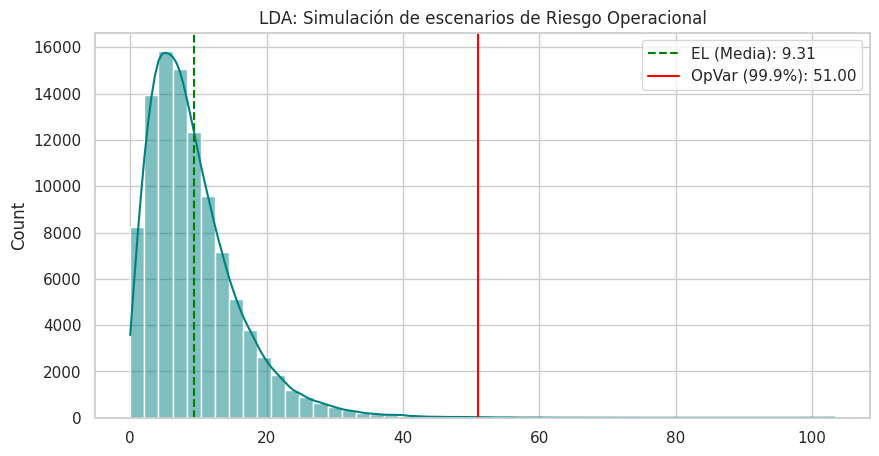

In [6]:
# --- CONFIGURACIÓN DE LA SIMULACIÓN ---

n_sim = 100000
mu_frec = Freq.mean()

# Ajuste estadístico
shape, loc, scale = stats.lognorm.fit(Sev[Sev > 0])

LDA_SIM = []
for _ in range(n_sim):
    n_eventos = np.random.poisson(mu_frec)
    if n_eventos > 0:
        p_dia = stats.lognorm.rvs(shape, loc, scale, size=n_eventos).sum()
        LDA_SIM.append(p_dia)
    else:
        LDA_SIM.append(0)

# El Capital en Riesgo (OpVar) al 99.9%
OpVar_999 = np.percentile(LDA_SIM, 99.9)
# --- CÁLCULO DE PARÁMETROS AMA (Imagen 3) ---
el = np.mean(LDA_SIM)                     # Pérdida Esperada
sl_999 = np.percentile(LDA_SIM, 99.9)    # Stress Loss (OpVar 99.9%)
ul = sl_999 - el                         # Pérdida No Esperada (Capital a reservar)

print("\n--- PARÁMETROS DE RIESGO AVANZADOS (MONTECARLO) ---")
print(f"Pérdida Esperada (EL): {el:.2f} Millones")
print(f"Capital en Riesgo (OpVar 99.9%): {sl_999:.2f} Millones")
print(f"Pérdida No Esperada (UL): {ul:.2f} Millones")

# Visualización del Riesgo Catastrófico
plt.figure(figsize=(10, 5))
sns.histplot(LDA_SIM, bins=50, kde=True, color="teal")
plt.axvline(el, color='green', linestyle='--', label=f'EL (Media): {el:.2f}')
plt.axvline(sl_999, color='red', linestyle='-', label=f'OpVar (99.9%): {sl_999:.2f}')
plt.title("LDA: Simulación de escenarios de Riesgo Operacional")
plt.legend()
plt.show()

## **Resultados de la integración de los datos**

1. *Métricas de Dipersión y Tendencia:*

Los estadísticos calculados en el análisis de la LDA revelan que los datos tienen una tendencia a ubicarse por la derecha por debajo pero muy cerca de la media, la cual se situa en 9.45 millones, siendo el costo promedio que la FINTECH asume como parte de su operación normal. El coeficiente de asimetría, al tener un valor positivo y considerable (3.35) indica que la mayoría de las pérdidas por tanto son de bajo monto, pero que existen eventos aislados de gran impacto.

La curtosis, al alcanzar un valor elevado (14.17), confirma un pico alto en las pérdidas pequeñas, y al mismo tiempo, una probabilidad de eventos extremos más alta que en una distribución normal. Esta volatilidad responde a los fallos críticos que pueden ocurrir en el sistema.

2. *Clusterización*

Al haber segmentado en 10 intervalos se identifica que el riesgo se concentra en los niveles **bajo/medio** (0.14 a 11.24 millones), que agrupa a 533 eventos. Según la tabla de niveles, estos corresponden a fallos menores y problemas de uso con frecuencia "Muy Alta".

Por otro lado, los últimos intervalos (clústeres del 8 al 9) muestran eventos con pérdidas superiores a los 90 y 100 millones, con una frecuencia "Muy Baja" (1 evento por clúster), pero que en si representan un riesgo de quiebra o parálisis como describe el Nivel 5 de impacto.

3. *Evaluación del Capital en Riesgo (metodología AMA)*

Siguiendo una meta de confiabilidad del 99.9% usando Montecarlo, se identifica que el valor máximo de pérdida en un escenario de estrés (OpVar) es de 102.90 millones, monto que la FINTECH debe considerar para solventarse ante desastres tecnológicos, y que la Pérdida No Esperada (UL) se calcula en 93.45 millones, siendo la diferencia de la variable anterior con la media, siendo el capital que debe reservarse o provisionarse para cubir desviaciones extremas que no forman parte del costo operativo normal.

Se concluye que la FINTECH está en una zona de alta frecuencia y de bajo impacto, pero sensible a eventos de baja frecuencia y de alto impacto, hecho que se refuerza a que el costo de mitigación (0.6283 KUSD) es ínfimo comparado con la Pérdida No Esperada (UL) de 93.45 millones, la recomendación estratégica entonces es la mitigación inmediata. Invertir en gestión permite reducir este capital reservado, liberando recursos para la expansión del negocio en lugar de mantenerlos inmovilizados para cubrir posibles desastres.